In [1]:
# prompt: Need help in deriving PCA for a dataset. I need sample code. Also, I would like to use the dataset LuFlow which is available in my Google Drive. I think I need to do data engineering on the dataset. Can you give the step by step example and the code accordingly?
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 22.8 MB/s eta 0:00:00


In [3]:
import lightgbm as lgb
import catboost as cb

In [ ]:
### To check whether GPU is used.
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available and being used.")
    print("GPU Details:", gpu_available)
else:
    print("GPU is not available. Using CPU.")

GPU is available and being used.
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report,roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [5]:
from google.colab import drive
drive.mount('/content/drive')
# Define the file path to your dataset in Google Drive
#file_path = '/content/drive/MyDrive/LuFlow.csv'
#file_path = '/content/drive/MyDrive/VIT/Dataset/LuFlow2021/luflow.csv'


Mounted at /content/drive


In [6]:
# Define the file paths in Google Drive
file_parquet_prepro = '/content/drive/MyDrive/VIT/Dataset/CIC-DDoS2019/cic-ddos2019-parquet-preprocessed.csv'


# Read the CSV files back into pandas DataFrames
df_parquet_prepro = pd.read_csv(file_parquet_prepro)

# Optional: Display the first few rows and shape to verify they are loaded correctly
print("First 5 rows of df_with_entropies_loaded:")
print(df_parquet_prepro.head())
print("\nShape of df_with_entropies_loaded:")
print(df_parquet_prepro.shape)

First 5 rows of df_with_entropies_loaded:
   Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0        17          11207                182                       0   
1        17            211                 58                       0   
2        17            751                 86                       0   
3        17           1064                100                       0   
4        17            807                 26                       0   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                   80080.0                       0.0                  440.0   
1                   25376.0                       0.0                  440.0   
2                   37408.0                       0.0                  440.0   
3                   44000.0                       0.0                  440.0   
4                   11440.0                       0.0                  440.0   

   Fwd Packet Length Min  Fwd Packet L

In [8]:
# Access the dtypes attribute
feature_data_types = df_parquet_prepro.dtypes

# Print the data types
print("Data Types of Features:")
print(feature_data_types)

Data Types of Features:
Protocol                      int64
Flow Duration                 int64
Total Fwd Packets             int64
Total Backward Packets        int64
Fwd Packets Length Total    float64
                             ...   
Idle Mean                   float64
Idle Std                    float64
Idle Max                    float64
Idle Min                    float64
Label                        object
Length: 78, dtype: object


In [9]:
df_parquet_prepro['Label'] = df_parquet_prepro['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [10]:
#Get the counts of each unique label
label_counts = df_parquet_prepro['Label'].value_counts()

#Print the results

print("\nCounts of Each Label:")
print(label_counts)


Counts of Each Label:
Label
1    105677
0     97831
Name: count, dtype: int64


**Now Proceed With Entropies as the Entropy calculation is done by the Luflow dataset providers itself.**

In [11]:
def dropInfNull(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print (df.shape)

    return df

In [12]:
%%time
network_data_d1 = dropInfNull(df_parquet_prepro)

(203508, 78)
(203508, 78)
CPU times: user 142 ms, sys: 157 ms, total: 300 ms
Wall time: 297 ms


In an anomaly detection context, "outlier" often signifies something unusual or potentially suspicious, even if it doesn't fit a known malicious signature. Grouping "malicious" and "outlier" together allows your model to learn to distinguish between "normal" traffic and any form of unusual or potentially harmful traffic captured in these two categories.

In [14]:
df_balanced = network_data_d1

**Understanding the Data Type of the Dataset**

In [15]:
# Access the dtypes attribute
feature_data_types = df_balanced.dtypes

# Print the data types
print("Data Types of Features:")
print(feature_data_types)

Data Types of Features:
Protocol                      int64
Flow Duration                 int64
Total Fwd Packets             int64
Total Backward Packets        int64
Fwd Packets Length Total    float64
                             ...   
Idle Mean                   float64
Idle Std                    float64
Idle Max                    float64
Idle Min                    float64
Label                         int64
Length: 78, dtype: object


**Drop Constant Column**

In [16]:
%%time
# drop the constant columns (which varience is 0)
variances = df_balanced.var(numeric_only=True)
constant_columns = variances[variances == 0].index
df_balanced = df_balanced.drop(constant_columns, axis=1)

print(constant_columns)
print (df_balanced.shape)

Index(['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count',
       'PSH Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')
(203508, 66)
CPU times: user 69.9 ms, sys: 21.3 ms, total: 91.1 ms
Wall time: 89.6 ms


**Drop Duplicate Column**

In [17]:
duplicates = set()
for i in range(0, len(df_balanced.columns)):
    col1 = df_balanced.columns[i]
    for j in range(i+1, len(df_balanced.columns)):
        col2 = df_balanced.columns[j]
        if(df_balanced[col1].equals(df_balanced[col2])):
            duplicates.add(col2)

print (duplicates)
df_balanced.drop(duplicates, axis=1, inplace=True)
print (df_balanced.shape)

{'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Bwd Packets', 'RST Flag Count'}
(203508, 61)


**Drop Columns based on correlation**

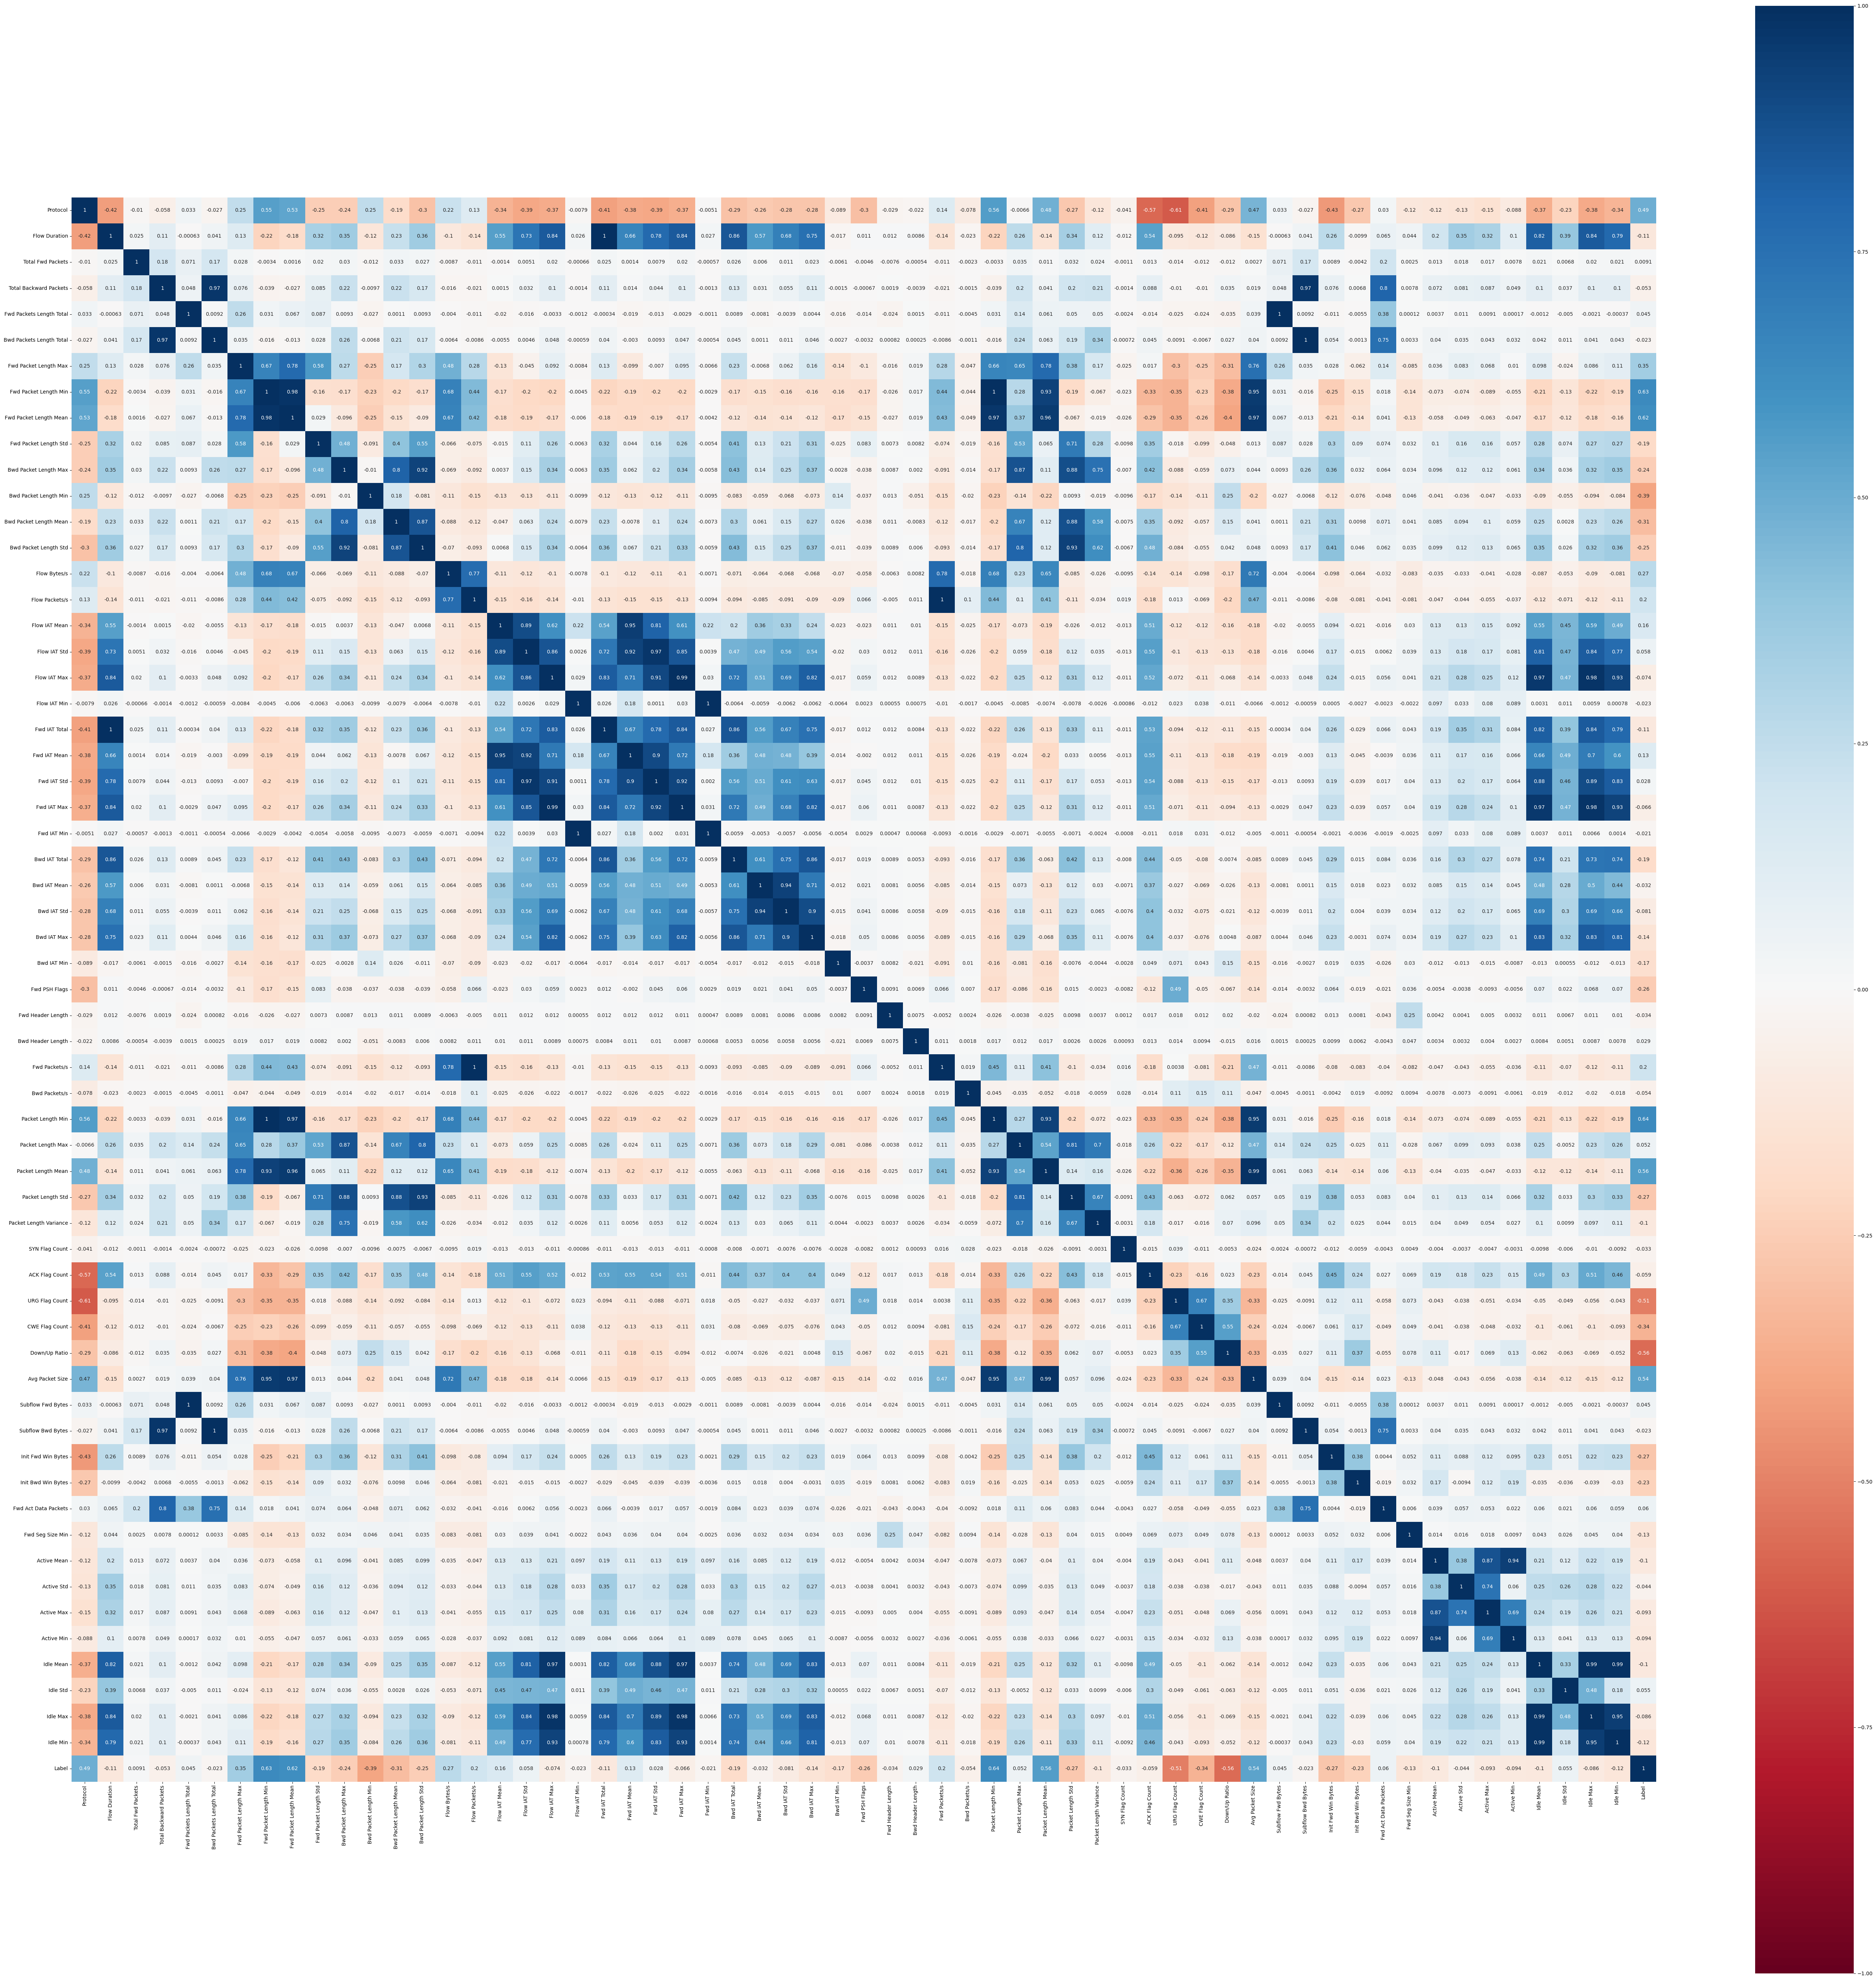

CPU times: user 8.74 s, sys: 313 ms, total: 9.05 s
Wall time: 9.01 s


In [18]:
%%time
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = df_balanced.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

In [19]:
%%time
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

{'Flow IAT Max', 'Bwd Packet Length Max', 'Packet Length Min', 'Fwd IAT Mean', 'Flow Duration', 'Flow IAT Std', 'Fwd Packet Length Mean', 'Flow Packets/s', 'Bwd Packets Length Total', 'Idle Mean', 'Fwd IAT Max', 'Packet Length Mean', 'Bwd IAT Mean', 'Fwd IAT Std', 'Flow IAT Min', 'Idle Max', 'Active Mean', 'Flow IAT Mean', 'Bwd Packet Length Std', 'Fwd Packets Length Total', 'Fwd Packet Length Min', 'Total Backward Packets'}
22
CPU times: user 33.9 ms, sys: 0 ns, total: 33.9 ms
Wall time: 33.6 ms


In [20]:
%%time
df_balanced.drop(correlated_col, axis=1, inplace=True)
print (df_balanced.shape)

(203508, 39)
CPU times: user 12 ms, sys: 10.3 ms, total: 22.3 ms
Wall time: 20.3 ms


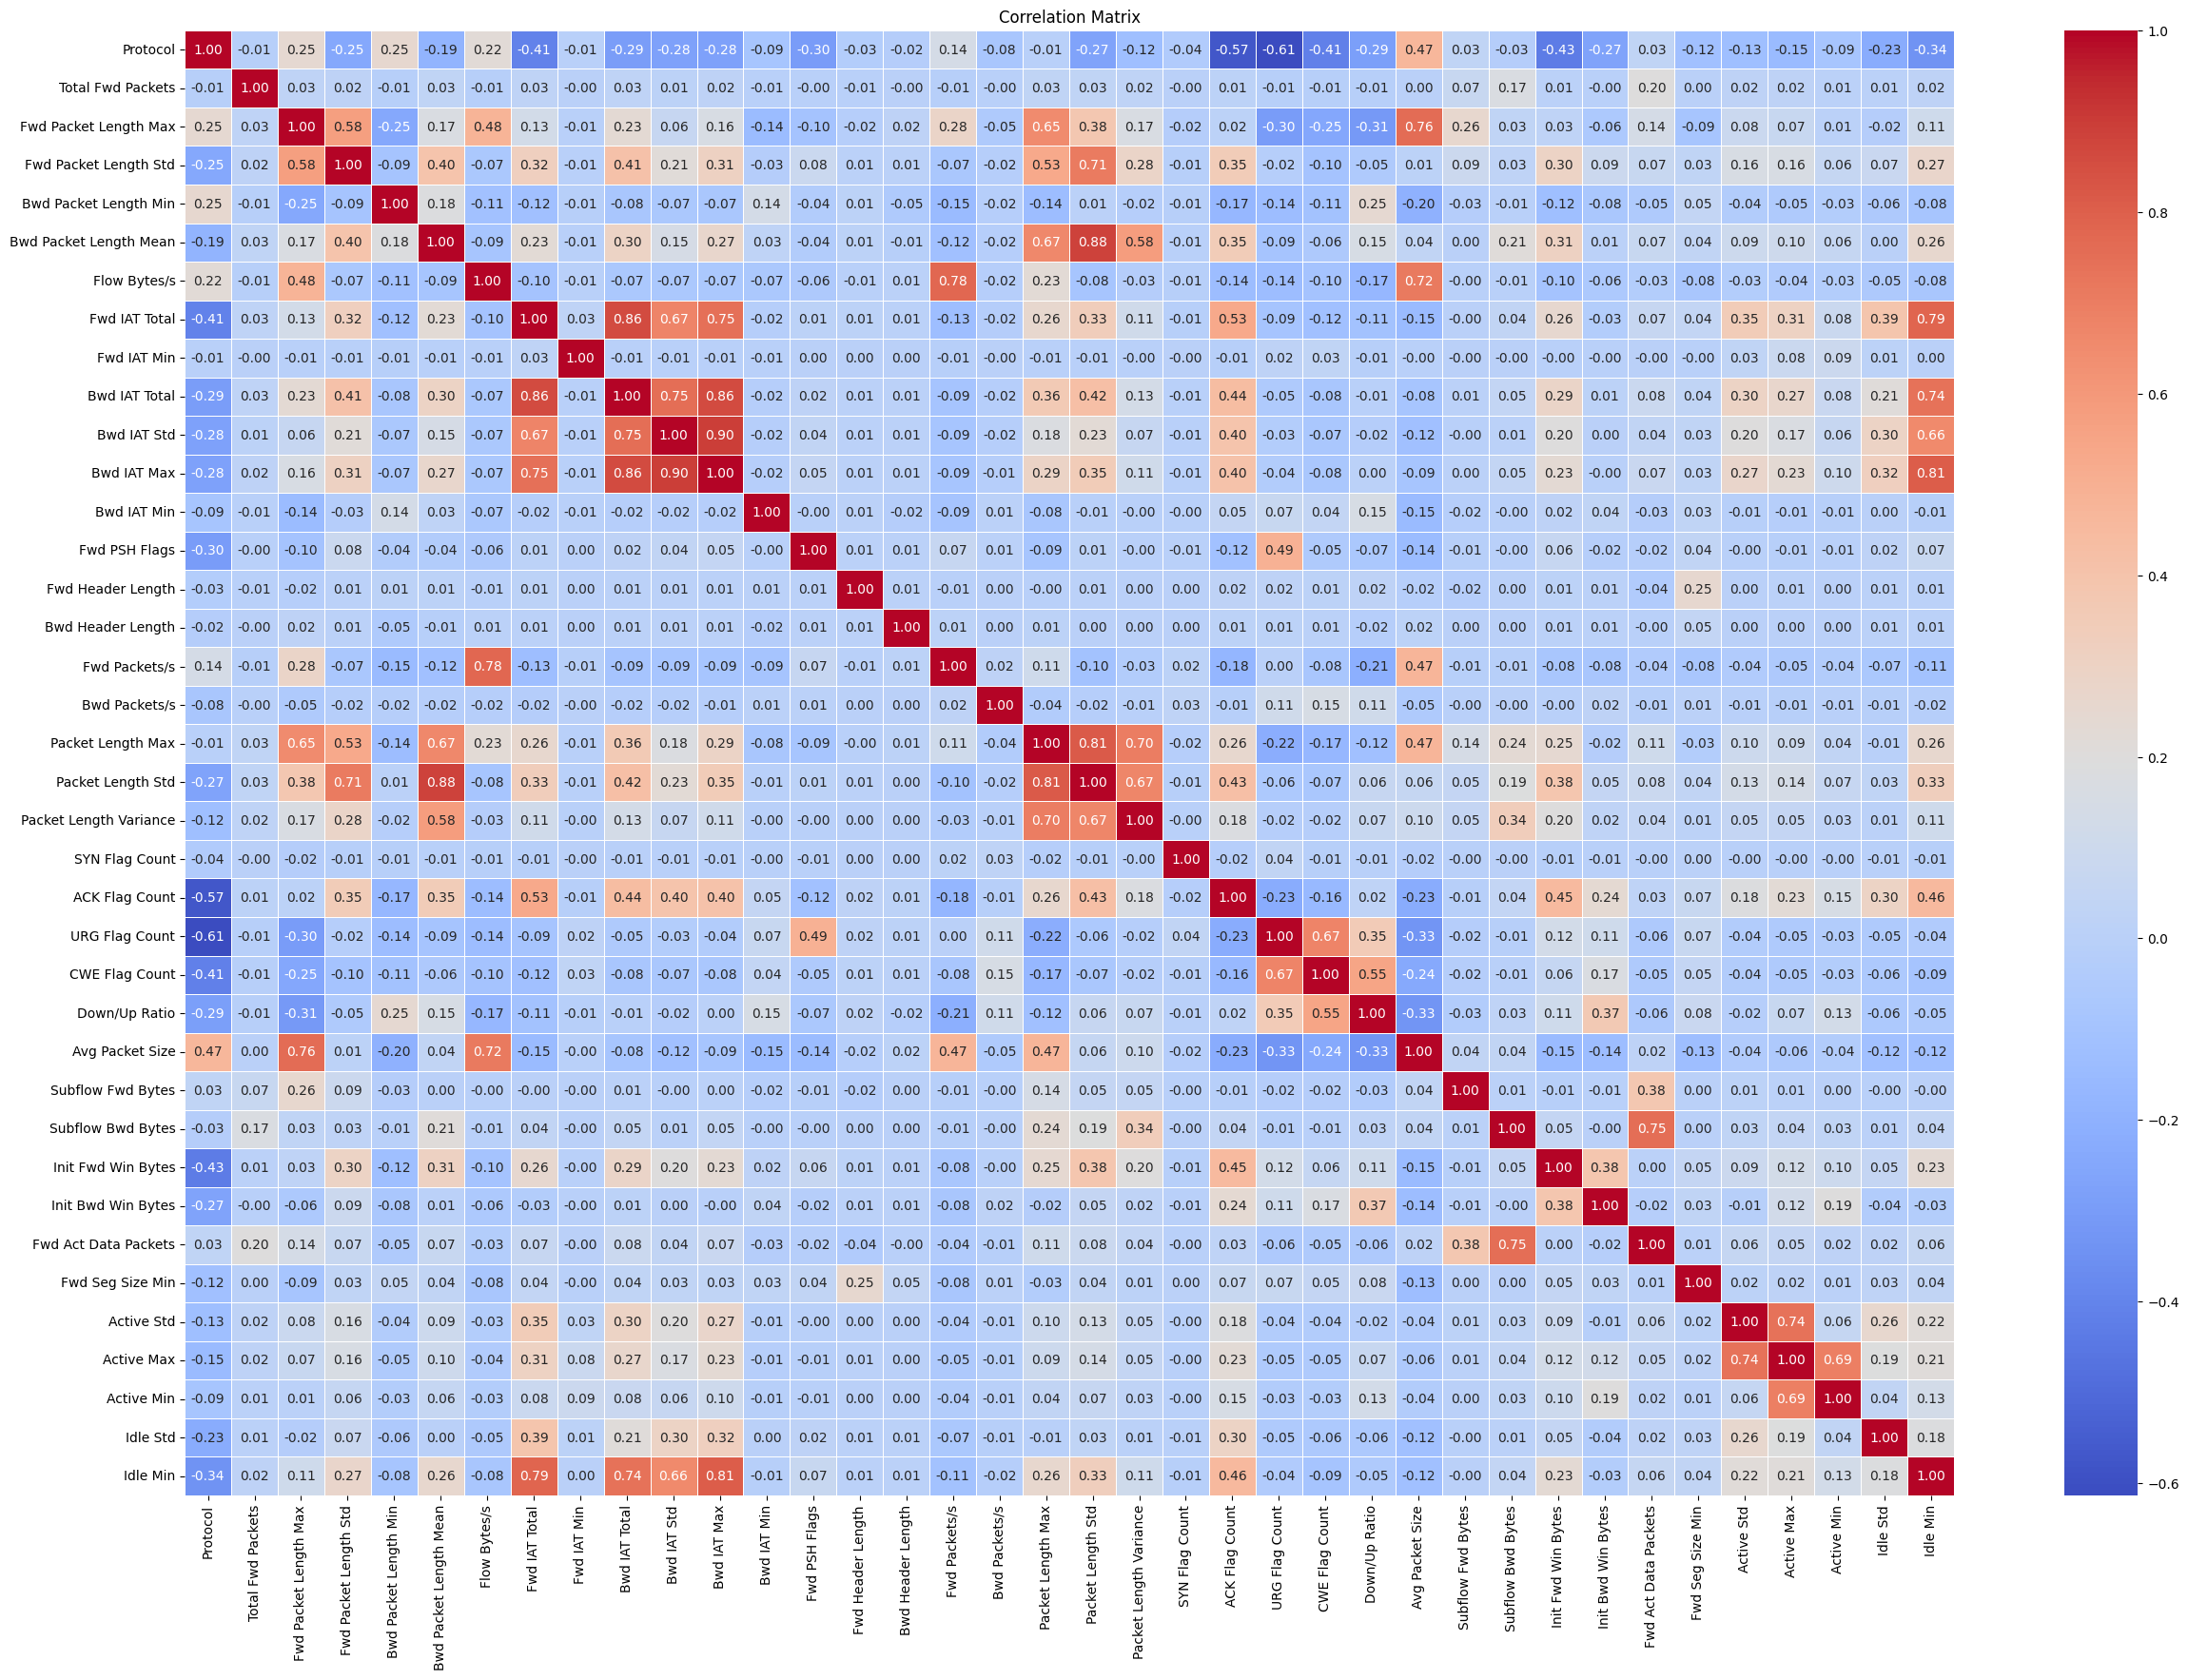

In [23]:
# Calculate correlation matrix
correlation_matrix = df_balanced.drop('Label', axis=1).corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

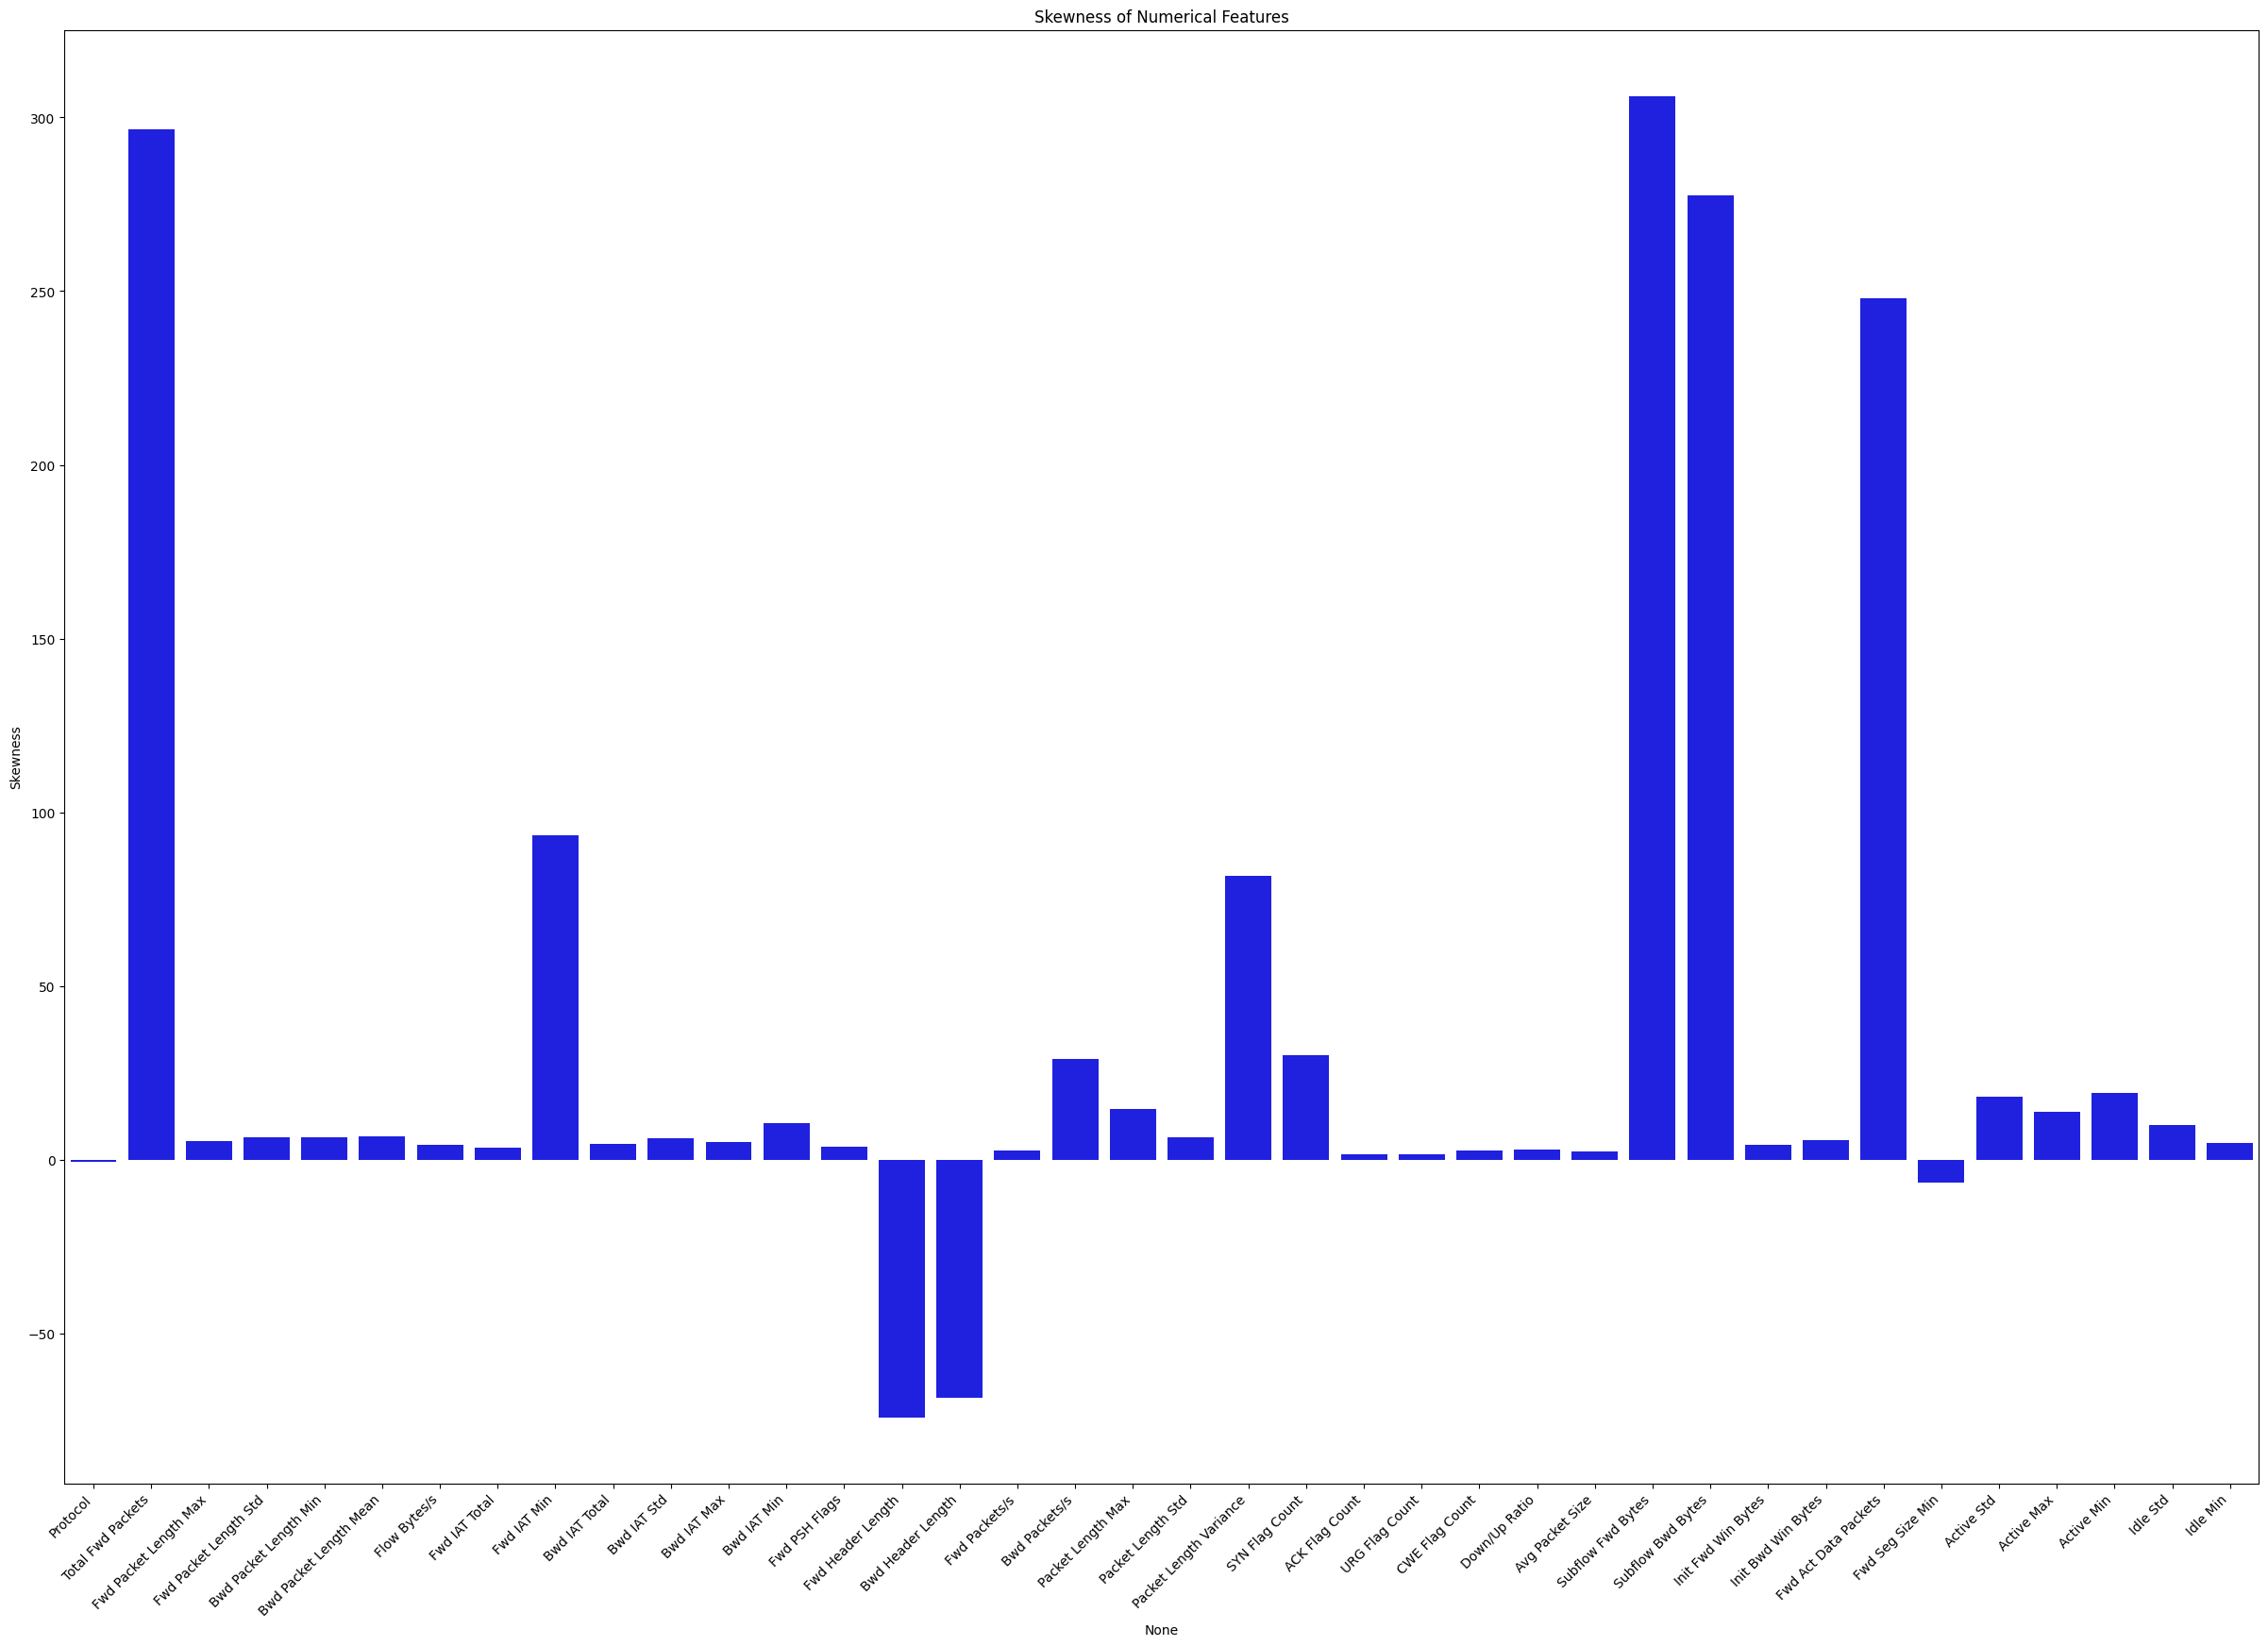

In [24]:
# Calculate skewness for each numerical column
skewness = df_balanced.drop('Label', axis=1).skew()

# Create a bar plot or a histogram of skewness values
plt.figure(figsize=(30, 20))
sns.barplot(x=skewness.index, y=skewness.values, color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Skewness of Numerical Features')
plt.ylabel('Skewness')
plt.show()

In [25]:
%%time
X=df_balanced.drop(["Label"], axis=1)
y=df_balanced["Label"]

# split the data for evaluation
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state =42, shuffle=True)

CPU times: user 75.2 ms, sys: 13.1 ms, total: 88.4 ms
Wall time: 86.5 ms


In [26]:
x_train

Protocol  Total Fwd Packets  Fwd Packet Length Max  \
10790         17                114                  440.0   
61313         17                  6                  393.0   
26925         17                  4                  516.0   
136032        17                  2                 1257.0   
123567         6                  4                   46.0   
...          ...                ...                    ...   
119879        17                  2                 1272.0   
103694         6                  1                    6.0   
131932        17                  2                  925.0   
146867         6                  1                    0.0   
121958         6                 57                 3174.0   

        Fwd Packet Length Std  Bwd Packet Length Min  Bwd Packet Length Mean  \
10790                0.000000                    0.0                 0.00000   
61313               35.088460                    0.0                 0.00000   
26925                0.000000                    0.0                 0.00000   
136032               0.000000                    0.0                 0.00000   
123567              26.558113                    0.0                23.00000   
...                       ...                    ...                     ...   
119879               0.000000                    0.0                 0.00000   
103694               0.000000                    6.0                 6.00000   
131932               0.000000                    0.0                 0.00000   
146867               0.000000                    0.0                 0.00000   
121958             991.459960                    0.0               180.69841   

        Flow Bytes/s  Fwd IAT Total  Fwd IAT Min  Bwd IAT Total  ...  \
10790   4.549660e+06        11025.0          0.0            0.0  ...   
61313   9.826807e+03       212480.0          0.0            0.0  ...   
26925   6.888323e+02      2996375.0          1.0            0.0  ...   
136032  2.514000e+09            1.0          1.0            0.0  ...   
123567  2.365951e+03        77770.0          1.0            5.0  ...   
...              ...            ...          ...            ...  ...   
119879  2.544000e+09            1.0          1.0            0.0  ...   
103694  9.424084e+04            0.0          0.0            2.0  ...   
131932  9.250000e+08            2.0          2.0            0.0  ...   
146867  0.000000e+00            0.0          0.0            0.0  ...   
121958  4.246734e+02    110384100.0          0.0    110384030.0  ...   

        Subflow Bwd Bytes  Init Fwd Win Bytes  Init Bwd Win Bytes  \
10790                   0                  -1                  -1   
61313                   0                  -1                  -1   
26925                   0                  -1                  -1   
136032                  0                  -1                  -1   
123567                 92                 258                 311   
...                   ...                 ...                 ...   
119879                  0                  -1                  -1   
103694                 12                 246               16421   
131932                  0                  -1                  -1   
146867                  0                 253                 245   
121958              11384                8192                 556   

        Fwd Act Data Packets  Fwd Seg Size Min  Active Std  Active Max  \
10790                    113                20         0.0         0.0   
61313                      5                20         0.0         0.0   
26925                      3                -1         0.0         0.0   
136032                     1                 0         0.0         0.0   
123567                     1                20         0.0         0.0   
...                      ...               ...         ...         ...   
119879                     1              1480         0.0         0.0   
103694          

In [27]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training set
x_train = scaler.fit_transform(x_train)

# Transform the testing set using the same scaler
x_test = scaler.transform(x_test)

In [28]:
# --- LightGBM Model ---
print("--- Training LightGBM Model ---")

# Initialize LightGBM classifier
lgb_clf = lgb.LGBMClassifier(random_state=42)

# Train the model
lgb_clf.fit(x_train, y_train)

--- Training LightGBM Model ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 84564, number of negative: 78242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7611
[LightGBM] [Info] Number of data points in the train set: 162806, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519416 -> initscore=0.077702
[LightGBM] [Info] Start training from score 0.077702


LGBMClassifier(random_state=42)

In [29]:
# Make predictions (probabilities) on the test set
y_pred_proba_lgb = lgb_clf.predict_proba(x_test)[:, 1]

# Make predictions (binary) on the test set
y_pred_lgb = lgb_clf.predict(x_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


:# **Calculate the Metrics for Light GBM**



In [41]:
print("--- LightGBM ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lgb))

--- LightGBM ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19589
           1       1.00      1.00      1.00     21113

    accuracy                           1.00     40702
   macro avg       1.00      1.00      1.00     40702
weighted avg       1.00      1.00      1.00     40702

ROC AUC Score:
0.9999984465012145


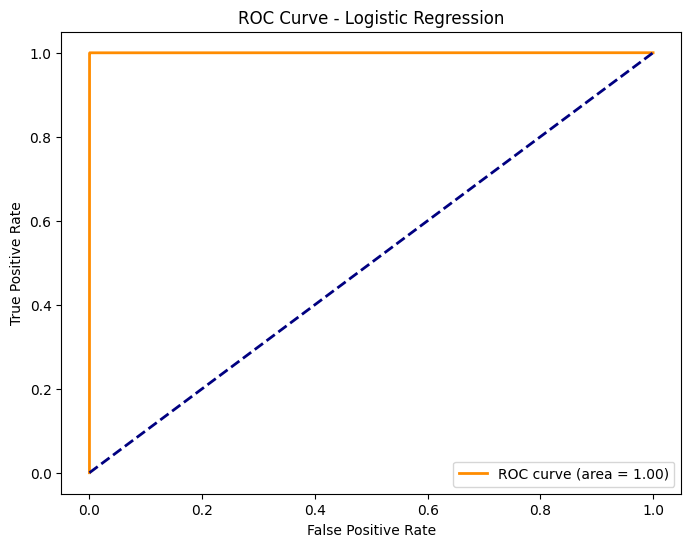

In [31]:
# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lgb)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [32]:
# Calculate the confusion matrix
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

# Print the confusion matrix
print("Confusion Matrix for Logistic Regression:")
print(conf_matrix_lgb)

Confusion Matrix for Logistic Regression:
[[19580     9]
 [   10 21103]]


In [33]:
# Extract TN, FP, FN, TP from the confusion matrix
# The confusion matrix structure for binary classification in sklearn is:
# [[TN, FP],
#  [FN, TP]]
tn, fp, fn, tp = conf_matrix_lgb.ravel()

# Print the values
print("\nConfusion Matrix Components:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Confusion Matrix Components:
True Negatives (TN): 19580
False Positives (FP): 9
False Negatives (FN): 10
True Positives (TP): 21103


--- LightGBM Feature Importance ---


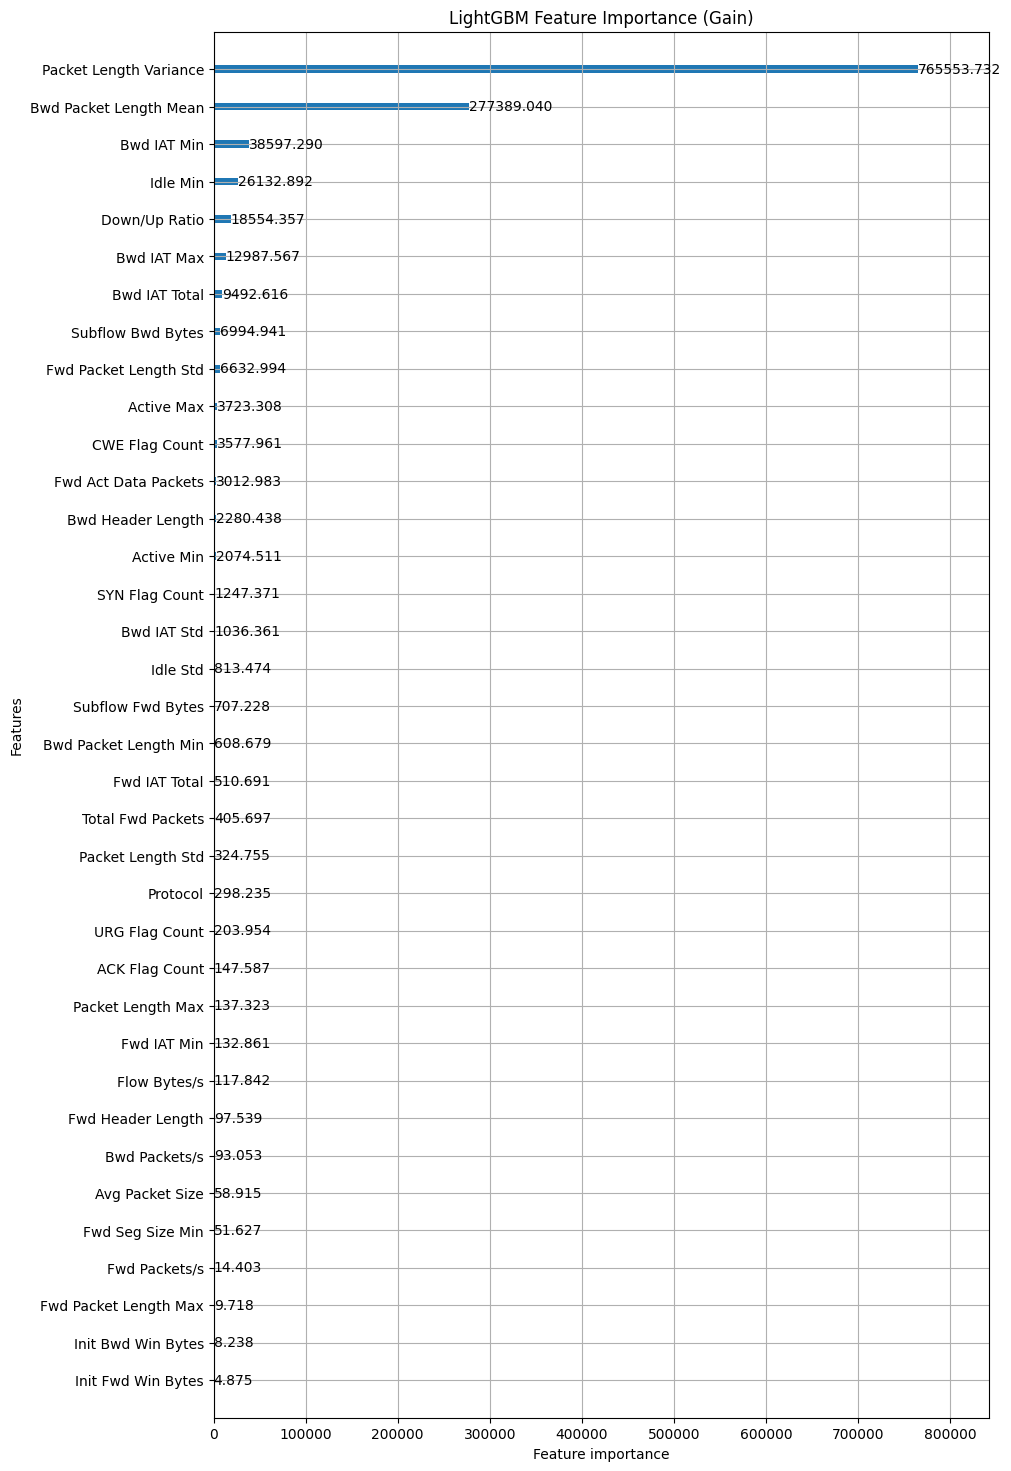

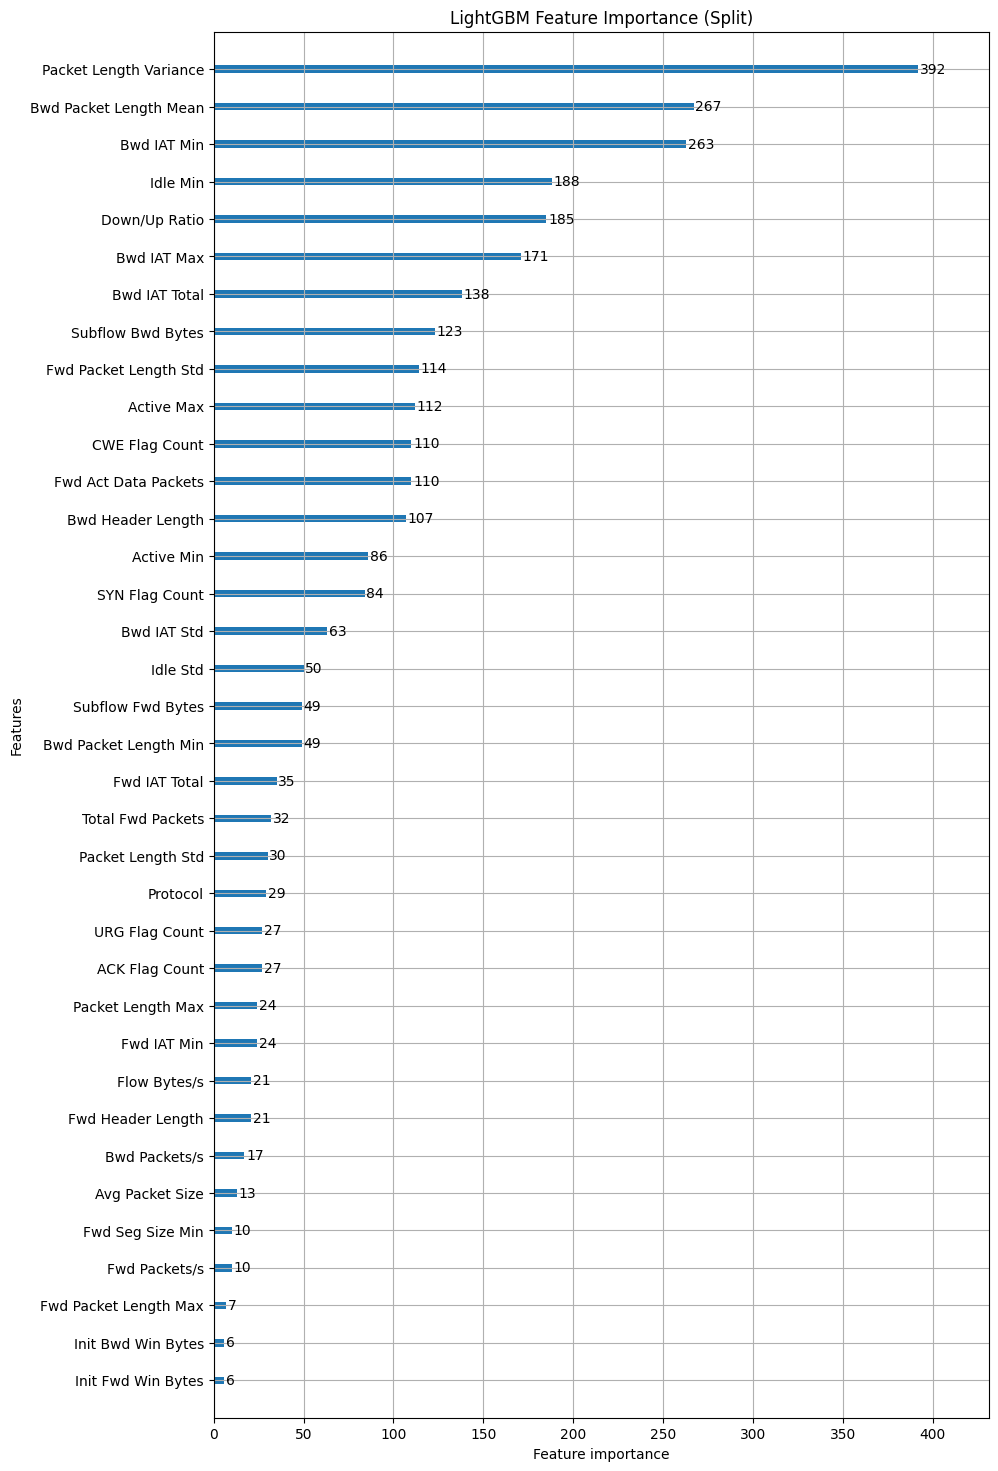

In [47]:
# Plot feature importance for LightGBM
print("--- LightGBM Feature Importance ---")

# Get the feature names from the training data
feature_names = X.columns.tolist()

# Get feature importances from the trained model
importance_gain = lgb_clf.feature_importances_
importance_split = lgb_clf.booster_.feature_importance(importance_type='split') # Use booster_ for split importance

# Create a list of (feature_name, importance) tuples
gain_importances = list(zip(feature_names, importance_gain))
split_importances = list(zip(feature_names, importance_split))

# Filter out features with zero importance for both gain and split
gain_importances_filtered = [(name, imp) for name, imp in gain_importances if imp > 0]
split_importances_filtered = [(name, imp) for name, imp in split_importances if imp > 0]

# Sort the filtered features by importance in descending order
gain_importances_filtered.sort(key=lambda x: x[1], reverse=True)
split_importances_filtered.sort(key=lambda x: x[1], reverse=True)

# Extract the sorted feature names
sorted_gain_feature_names = [name for name, imp in gain_importances_filtered]
sorted_split_feature_names = [name for name, imp in split_importances_filtered]

# Create a figure and axes for the gain plot
fig_gain, ax_gain = plt.subplots(figsize=(10, len(sorted_gain_feature_names) * 0.5)) # Adjust figure size based on number of features

# Pass the axes object to plot_importance.
# We still pass the clf and ax, and let plot_importance handle the plotting logic.
# It will plot the features with importance > 0 by default.
lgb.plot_importance(lgb_clf, importance_type='gain', ax=ax_gain, max_num_features=len(sorted_gain_feature_names)) # Set max_num_features to match filtered list
plt.title('LightGBM Feature Importance (Gain)')
# Set the y-axis tick labels using the filtered and sorted feature names
ax_gain.set_yticklabels(sorted_gain_feature_names)
plt.show()

# Create a figure and axes for the split plot
fig_split, ax_split = plt.subplots(figsize=(10, len(sorted_split_feature_names) * 0.5)) # Adjust figure size

# Pass the axes object to plot_importance
lgb.plot_importance(lgb_clf, importance_type='split', ax=ax_split, max_num_features=len(sorted_split_feature_names)) # Set max_num_features to match filtered list
plt.title('LightGBM Feature Importance (Split)')
# Set the y-axis tick labels using the filtered and sorted feature names
ax_split.set_yticklabels(sorted_split_feature_names)
plt.show()



```

```

**CatBoost**

In [34]:
# Initialize CatBoost classifier
# 'verbose=0' suppresses training output
cat_clf = cb.CatBoostClassifier(iterations=100, # Number of trees
                                 learning_rate=0.1,
                                 loss_function='Logloss', # For binary classification
                                 eval_metric='AUC',
                                 random_state=42,
                                 verbose=0)

In [35]:
# Train the model
cat_clf.fit(x_train, y_train)

In [36]:
# Make predictions (probabilities) on the test set
y_pred_proba_cat = cat_clf.predict_proba(x_test)[:, 1]

In [37]:
# Make predictions (binary) on the test set
y_pred_cat = cat_clf.predict(x_test)

--- CatBoost ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19589
           1       1.00      1.00      1.00     21113

    accuracy                           1.00     40702
   macro avg       1.00      1.00      1.00     40702
weighted avg       1.00      1.00      1.00     40702

ROC AUC Score:
0.9999915071369898


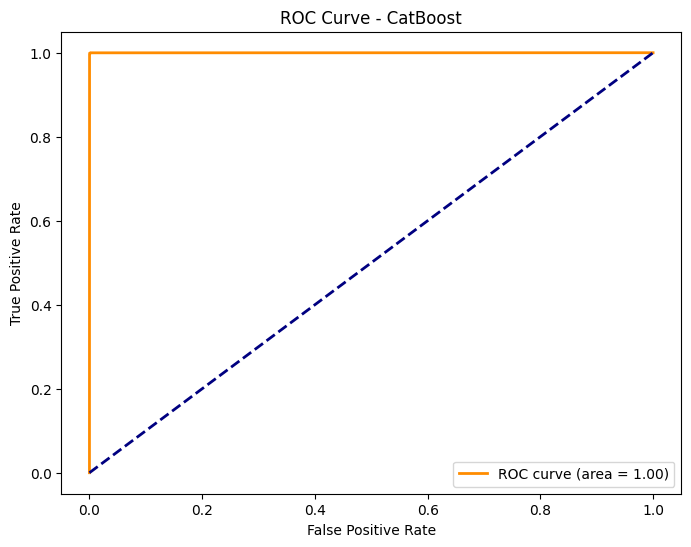

In [38]:
# Evaluate
print("--- CatBoost ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_cat))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_cat))
# Plot ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_cat)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc="lower right")
plt.show()

In [39]:
# Calculate the confusion matrix
conf_matrix_cat = confusion_matrix(y_test, y_pred_cat)

# Print the confusion matrix
print("Confusion Matrix for CatBoost:")
print(conf_matrix_cat)

Confusion Matrix for CatBoost:
[[19573    16]
 [   18 21095]]


In [40]:
# Extract TN, FP, FN, TP from the confusion matrix
# The confusion matrix structure for binary classification in sklearn is:
# [[TN, FP],
#  [FN, TP]]
tn, fp, fn, tp = conf_matrix_cat.ravel()

# Print the values
print("\nConfusion Matrix Components:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


Confusion Matrix Components:
True Negatives (TN): 19573
False Positives (FP): 16
False Negatives (FN): 18
True Positives (TP): 21095


--- CatBoost Feature Importance ---


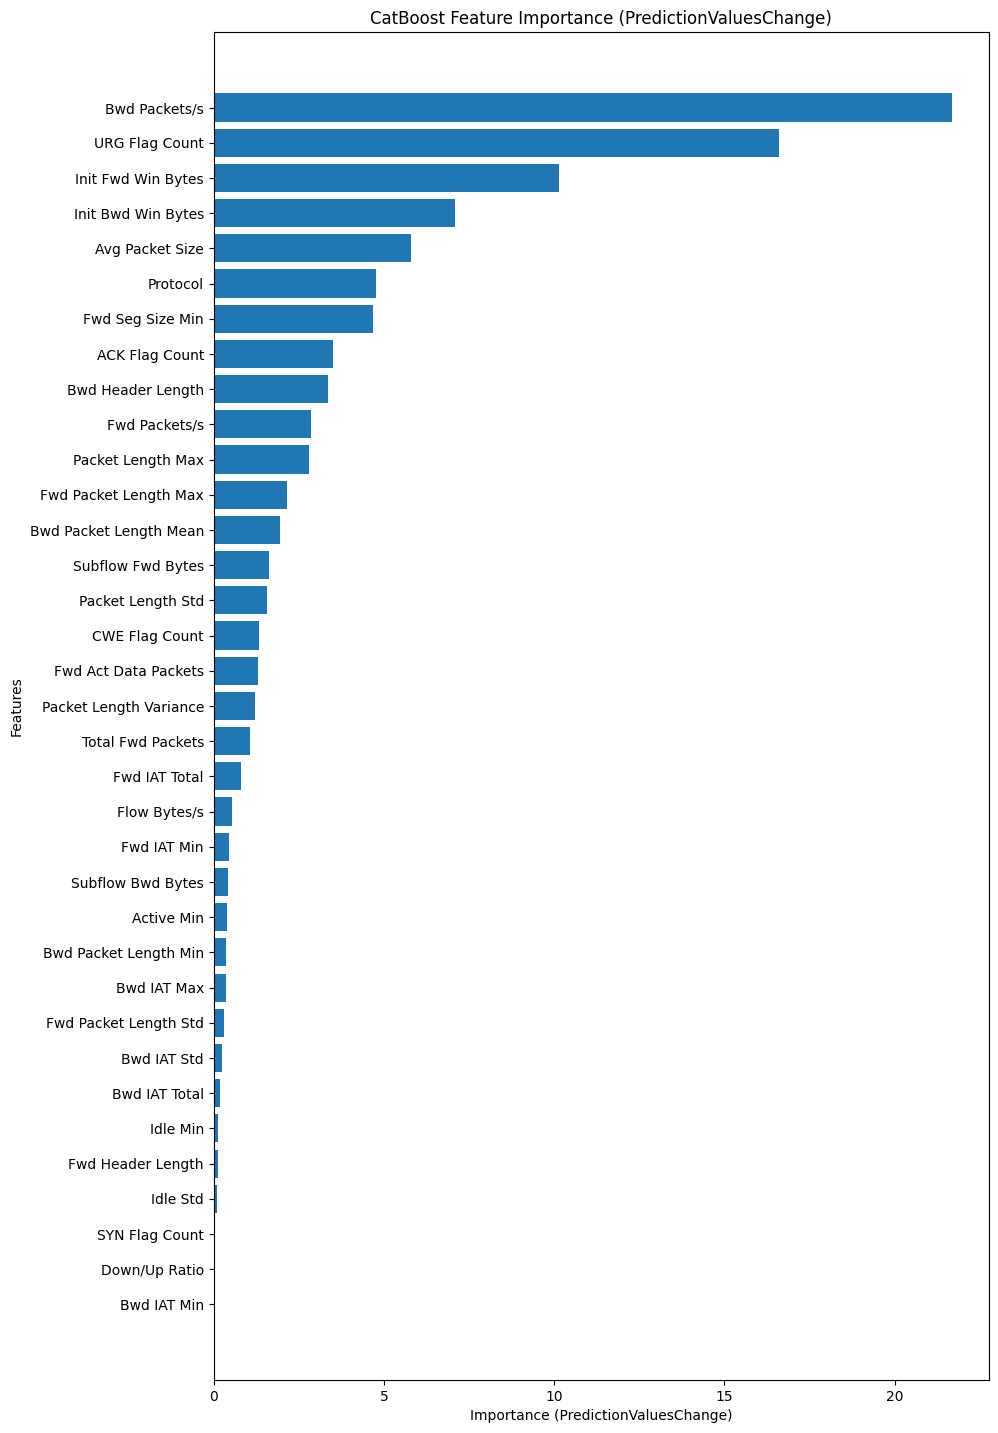

In [49]:
# Plot feature importance for CatBoost
print("--- CatBoost Feature Importance ---")

# Get the feature names from the training data (same as for LightGBM)
feature_names = X.columns.tolist()

# Get feature importances from the trained CatBoost model
# Using 'PredictionValuesChange' importance type
# Correcting the call to get_feature_importance by passing the type as the first argument
importance_catboost = cat_clf.get_feature_importance(type='PredictionValuesChange') # Use 'type' argument

# Create a list of (feature_name, importance) tuples
catboost_importances = list(zip(feature_names, importance_catboost))

# Filter out features with zero importance
catboost_importances_filtered = [(name, imp) for name, imp in catboost_importances if imp > 0]

# Sort the filtered features by importance in descending order
catboost_importances_filtered.sort(key=lambda x: x[1], reverse=True)

# Extract the sorted feature names and importances for plotting
sorted_catboost_feature_names = [name for name, imp in catboost_importances_filtered]
sorted_catboost_importances_values = [imp for name, imp in catboost_importances_filtered]

# Create a figure and axes for the CatBoost feature importance plot
fig_cat, ax_cat = plt.subplots(figsize=(10, len(sorted_catboost_feature_names) * 0.5)) # Adjust figure size

# Create a bar plot of the filtered and sorted feature importances
ax_cat.barh(sorted_catboost_feature_names, sorted_catboost_importances_values)

plt.title('CatBoost Feature Importance (PredictionValuesChange)')
plt.xlabel('Importance (PredictionValuesChange)')
plt.ylabel('Features')
# Invert the y-axis to have the most important feature at the top
ax_cat.invert_yaxis()
plt.show()